In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import os
import cv2
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from torch.cuda.amp import autocast, GradScaler

C:\Users\matsvei\AppData\Local\Temp\ipykernel_17688\3869485846.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
        
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
    
    def __getitem__(self, idx):
        
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
            
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # bgr to rgb
        img = img.astype(np.float32)
        img = img / 255.0
        
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        
        img  = img.transpose([2, 0, 1])
        
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor([class_id])
        
        
        return {'img': t_img, 'label': t_class_id}

    

In [3]:
train_dogs_path = 'D:/matvei/datasets/dogs_and_cats/training_set/dogs'
train_cats_path = 'D:/matvei/datasets/dogs_and_cats/training_set/cats'

test_dogs_path = 'D:/matvei/datasets/dogs_and_cats/test_set/dogs'
test_cats_path = 'D:/matvei/datasets/dogs_and_cats/test_set/cats'


train_ds_catdogs = Dataset2class(train_dogs_path, train_cats_path)
test_ds_catdogs = Dataset2class(test_dogs_path, test_cats_path)

In [4]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(
    train_ds_catdogs, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True
    )

test_loader = torch.utils.data.DataLoader(
   test_ds_catdogs, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False
   )

In [5]:
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, out_nc):
        super().__init__()
        
        self.act = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(512, 128)
        #self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(128, out_nc)
        
    def forward(self, x):
        out = self.conv1_1(x)
        out = self.act(out)
        out = self.conv1_2(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv2_1(out)
        out = self.act(out)
        out = self.conv2_2(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv3_1(out)
        out = self.act(out)
        out = self.conv3_2(out)
        out = self.act(out)
        out = self.conv3_3(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv4_1(out)
        out = self.act(out)
        out = self.conv4_2(out)
        out = self.act(out)
        out = self.conv4_3(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        # out = self.conv5_1(out)
        # out = self.act(out)
        # out = self.conv5_2(out)
        # out = self.act(out)
        # out = self.conv5_3(out)
        # out = self.act(out)
        
        # out = self.maxpool(out)
    
        out = self.avgpool(out)
        out = self.flat(out)
        
        out = self.fc1(out)
        out = self.act(out)
        # out = self.fc2(out)
        # out = self.act(out)
        out = self.fc3(out)
        
        return out

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
torch.cuda.empty_cache()

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE 

'cuda'

In [9]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [10]:
model = VGG16(out_nc=1)
model = model.to(DEVICE)
count_parameters(model)

3719105

In [11]:
use_amp = True

In [12]:
def accuracy(model, label):
    answer = (F.sigmoid(pred.detach().cpu()).numpy() > 0.5) == (label.cpu().numpy() > 0.5)
    return answer.mean()

In [13]:
epochs = 7
loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [ ]:
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    pbar = tqdm(train_loader)
    for sample in pbar:
        img, label = sample['img'], sample['label']
        # label = F.one_hot(label, 2).float()
        img = img.to(DEVICE)
        label = label.float().to(DEVICE)
        optimizer.zero_grad()
        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, label)
        
        loss.backward()
        loss_item = loss.item()
        loss_val +- loss_item
        
        optimizer.step()
        
        acc_current = accuracy(model, label)
        acc_val += acc_current
        pbar.set_description(f'Loss: {loss_item:.4f}\taccuracy: {acc_current:.4f}')
        
    pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_val:.4f}')
    print(loss_val/len(train_loader))
    print(acc_val/len(train_loader))
        

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\matsvei\AppData\Local\Temp\ipykernel_17688\2045162080.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(use_amp):


In [14]:
torch.cuda.empty_cache()

In [59]:
model.eval()
test_loss = 0.0
test_acc = 0.0

for sample in tqdm(test_loader):
    with torch.no_grad():
        img, label = sample['img'], sample['label']
        
        img = img.to(DEVICE)
        label = label.float().to(DEVICE) 
        pred = model(img)


        loss = loss_fn(pred, label)
        test_loss += loss.item()

        batch_acc = accuracy(model, label)
        test_acc += batch_acc.item()

avg_test_loss = test_loss / len(test_loader)
avg_test_acc = test_acc / len(test_loader)

print(f'Test Loss: {avg_test_loss:.5f}, Test Accuracy: {avg_test_acc:.3f}')

  0%|          | 0/250 [00:00<?, ?it/s]

Test Loss: 0.61819, Test Accuracy: 0.669


In [99]:
def lusa_test(lusa_path):   
    lusa = cv2.imread(lusa_path, cv2.IMREAD_COLOR)
    lusa = cv2.cvtColor(lusa, cv2.COLOR_BGR2RGB)
    plt.imshow(lusa)
    plt.title("Фото животоного")
    plt.axis("off")
    plt.show()
    
    lusa = lusa.astype(np.float32) 
    lusa = lusa / 255.0 
    lusa = cv2.resize(lusa, (224, 224), interpolation=cv2.INTER_AREA)
        
    lusa = lusa.transpose([2, 0, 1])
    lusa_t = torch.from_numpy(lusa).unsqueeze(0) 
    lusa_class_id = torch.tensor(1)
    
    with torch.no_grad():
        lusa_t = lusa_t.float().to(DEVICE)
        lusa_class_id = lusa_class_id.long().to(DEVICE)
        pred = model(lusa_t)

        # Применяем сигмоиду, если это бинарная классификация
        probability = torch.sigmoid(pred)

        # Получаем вероятность того, что это собака
        prob_dog = probability.item()

        # Выводим вероятности для кошки и собаки
        prob_cat = 1 - prob_dog
        print(f"Вероятность, что это кошка: {prob_cat:.4f}")
        print(f"Вероятность, что это собака: {prob_dog:.4f}")


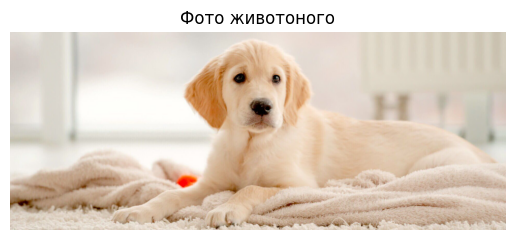

Вероятность, что это кошка: 0.3526
Вероятность, что это собака: 0.6474


In [106]:
path_lusa_1 = 'D:/matvei/datasets/dogs_and_cats/true_imgs/dog4.jpg'
lusa_test(path_lusa_1)